In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import binomtest, ttest_ind, chi2_contingency, f_oneway, chisquare, ttest_1samp
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

train_set = pd.read_csv("train_data.csv")
train_set.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,130453,15728005,Hargreaves,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,77297,15686810,Ts'ui,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,40858,15760244,Trevisano,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,19804,15810563,French,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


In [2]:
train_set["Exited"].value_counts()

Exited
0    113129
1     30450
Name: count, dtype: int64

On voit que les deux classes de la target sont assez désiquilibré et c'est pour cette raison qu'on utilisera la métrique f1_score.

#I) Définition des variables et des lignes

•   Customer ID : Un identifiant unique pour chaque client (discret)

•   Surname : Le nom de famille du client (discret)

•   Credit Score : Une valeur numérique représentant le score de crédit du client (continue)

•   Geography : Le pays où réside le client (France, Spain ou Germany) (discret)

•   Gender : Le genre du client (Male or Female) (discret)

•   Age : L’âge du client (C'est une variable discréte mais qu'on va traiter comme une variable continue)

•   Tenure : Le nombre d’années pendant lesquelles le client est avec la banque (discret)

•   Balance : Le solde du compte du client (continue)

•   NumOfProducts : Le nombre de produits bancaires utilisés par le client (par exemple, compte d’épargne, carte de crédit) (discret)

•   HasCrCard : Si le client possède une carte de crédit (1 = oui, 0 = non) (discret)

•   IsActiveMember : Si le client est un membre actif (1 = oui, 0 = non) (discret)

•   EstimatedSalary : Le salaire estimé du client (continue)

•   Exited : Si le client a résilié (1 = oui, 0 = non) (discret)

•   Pour la définition des lignes, c'est les clients.

#II) Analyse statistiques

#II.1) Analyse univarié de toutes les variables ainsi que l'analyse bivarié de toutes les variables avec la target

#II.1.1) Analyse du score de crédit.

#II.1.1.a) Analyse univarié

Le score de crédit est un indicateur de la capacité d'un client de payer ces dettes. Plus ce score est bas, plus le client n'est pas fiable. L'échelle et l'interprétation de ce score dépends du pays mais aussi de la banque.

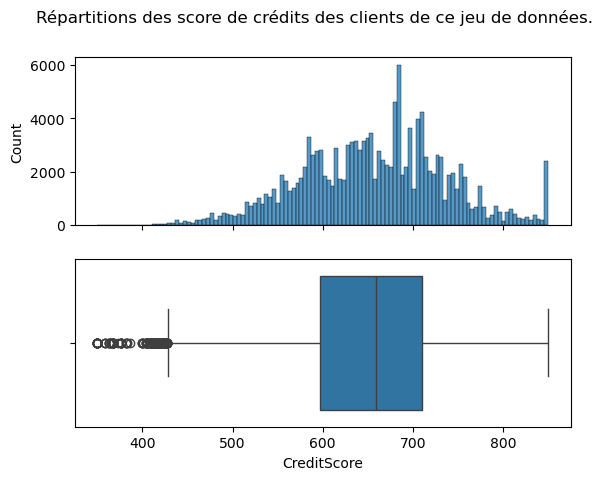

count    143579.000000
mean        656.411704
std          80.210361
min         350.000000
25%         597.000000
50%         659.000000
75%         710.000000
max         850.000000
Name: CreditScore, dtype: float64

In [3]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des score de crédits des clients de ce jeu de données.")
sns.histplot(data=train_set, x="CreditScore", ax=ax[0])
sns.boxplot(data=train_set, x="CreditScore", ax=ax[1])
plt.show()
train_set["CreditScore"].describe()

On observe que la moyenne des clients qui vive en France, Allemagne et Espagne est d'environ 656. On observe que les score de crédit suive clairement une loi normale. On observe quelque outliers à gauche de la boxplot qui correspond donc au client les moins fiables. On voit aussi que la plupart des clients ont un crédit de score entre 580 et 750. C'est-à-dire que la plupart des clients ont un score de crédit plutôt moyen.

#II.1.1.b) Analyse du crédit de score par rapport à la target

On va comparer les moyennes et les répartitions du score de crédit pour les clients qui ont résilié et ceux qui n'ont pas résilié.

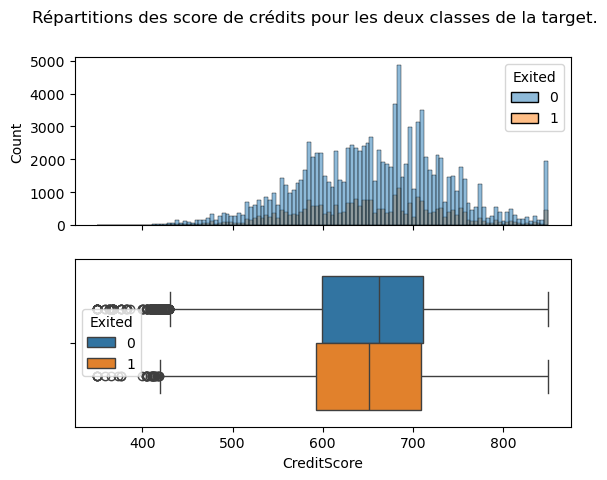

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,657.532136,79.899437,350.0,599.0,662.0,711.0,850.0
1,30450.0,652.249031,81.221163,350.0,593.0,651.0,709.0,850.0


In [4]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des score de crédits pour les deux classes de la target.")
sns.histplot(data=train_set, x="CreditScore", hue="Exited", ax=ax[0])
sns.boxplot(data=train_set, x="CreditScore", hue="Exited", ax=ax[1])
plt.show()
train_set.groupby("Exited")["CreditScore"].describe()

On observe qu'il y a une superposition des histogrammeset une légére différences au niveau des boxplots. On observe des outliers à gauche des deux boxplots. On observe que en moyennes les clients qui ont résilié sont moins fiables que les clients qui n'ont pas résilié.

In [5]:
print("H0: Les clients qui ont résilié ont en moyenne un score de crédit égale à ceux des clients qui n'ont pas résilié.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Exited` == 1")["CreditScore"], train_set.query("`Exited` == 0")["CreditScore"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont en moyenne un score de crédit égale à ceux des clients qui n'ont pas résilié.
Nous avons assez d'évidence pour rejeter H0


Comme on a assez d'évidence pour rejeter H0, on peut dire avec 2% de risque de ce trompé que le score de crédit moyens des clients qui ont résilié est bien inférieur à celui des clients qui n'ont pas résilié. On peut en conclure que les clients qui ont résilié sont en moyenne moins fiable que les clients qui n'ont pas résilié.

#II.1.2) Analyse du pays de résidence

#II.1.2.a) Analyse univarié

On va d'abord compter le nombre de client par pays de résidence.  

In [6]:
train_set["Geography"].value_counts()

Geography
France     81886
Spain      31588
Germany    30105
Name: count, dtype: int64

On voit que la plupart des clients vive en France. Ensuite il y a un nombre similaire de client qui vive en Espagne et en Allemagne avec légéremment plus de client en Espagne qu'en Allemagne.

#II.1.2.b) Analyse de geography en fonction de la target

In [7]:
pd.crosstab(train_set["Geography"], train_set["Exited"])

Exited,0,1
Geography,,
France,68338,13548
Germany,18657,11448
Spain,26134,5454


On voit que dans les deux cas, il y a plus de clients qui vivent en France. Ensuite on voit qu'il y a parmis les clients qui ont résilié plus de clients qui vive en Allemagne qu'en Espagne et c'est l'inverse pour les clients qui n'ont pas résilié. Maintenant testons si il y a bien une corrélation ente le pays de résidence et la target.

In [8]:
print("H0: Il n'y a pas de relation entre le pays de résidence et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["Geography"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le pays de résidence et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut donc dire avec un risque de ce trompé de 2% qu'il y a bien une relation entre le pays de résidence et la target.

#II.1.3) Analyse du genre

#II.1.3.a) Analyse univarié

In [9]:
train_set["Gender"].value_counts()

Gender
Male      80966
Female    62613
Name: count, dtype: int64

On voit qu'il y a plus d'homme que de femme dans cette banque.

#II.1.3.b) Analyse du genre par rapport à la target

In [10]:
pd.crosstab(train_set["Gender"], train_set["Exited"])

Exited,0,1
Gender,,
Female,45038,17575
Male,68091,12875


On voit qu'il y a plus de femme que d'hommes parmis les clients qui résilie et c'est l'inverse pour ceux qui ne résilie pas. On va maintenant tester si il y a bien une relation entre le genre et la target.

In [11]:
print("H0: Il n'y a pas de relation entre le genre et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["Gender"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le genre et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut donc dire avec un risque de se trompé de 2% qu'il y a bien une relation entre le genre et la target.

#II.1.4) Analyse de l'âge

#II.1.4.a) Analyse univarié

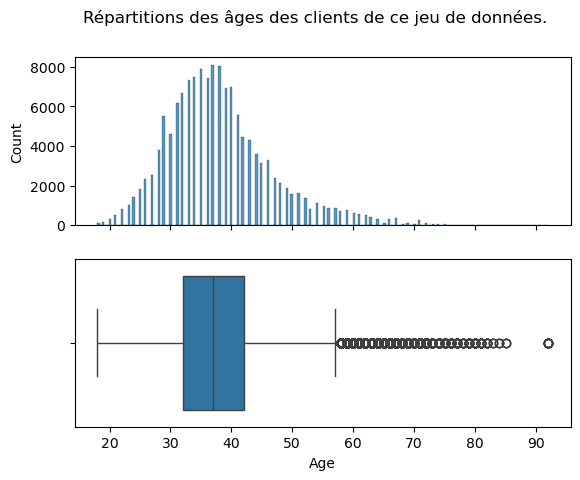

count    143579.000000
mean         38.144476
std           8.871711
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64

In [12]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des âges des clients de ce jeu de données.")
sns.histplot(data=train_set, x="Age", ax=ax[0])
sns.boxplot(data=train_set, x="Age", ax=ax[1])
plt.show()
train_set["Age"].describe()

On voit que la moyenne d'âge des clients de la banque qui vivent en France, Allemagne et Espagne est de 38 ans. On voit que l'âge suit une loi normale et il y a des outliers à droite de la boxplot. On voit que la plupart des clients ont entre 30 et 40 ans.

#II.1.4.b) Analyse de l'âge en fonction de la target

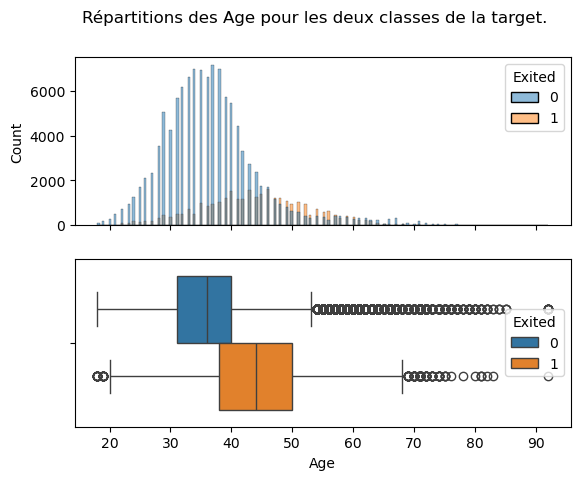

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,36.583765,8.166737,18.0,31.0,36.0,40.0,92.0
1,30450.0,43.942890,8.981339,18.0,38.0,44.0,50.0,92.0


In [13]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des Age pour les deux classes de la target.")
sns.histplot(data=train_set, x="Age", hue="Exited", ax=ax[0])
sns.boxplot(data=train_set, x="Age", hue="Exited", ax=ax[1])
plt.show()
train_set.groupby("Exited")["Age"].describe()

On observe qu'il y a une zone entre 48 ans et 55 ans dans lequel il y a plus de clients qui ont résilié que de client qui n'ont pas résilié. On observe que les deux boxplot sont relativement différent. On observe aussi que l'âge moyens des clients qui n'ont pas résilié est plus petit que la moyenne d'âge des clients qui ont résilié. On observe des outliers à droite des deux boxplot. On voit que la boxplot des clients qui n'ont pas résilié est moins étendues que la boxplot des clients qui ont résilié. On observe quelques outliers à gauche de la boxplot des clients qui ont résilié. On voit aussi que les deux histogramme sont des lois normale et que l'histogramme des clients qui ont résilié est décalé par rapport à l'autre histogramme. On a un début de séparation avec cette variable. On va faire un test de student et on va d'abords regarder les conditions d'utilisation. L'âge d'un client ne dépend pas des autres, tous les clients sont issues de la même population, il y a plus de 30 points par classes et les variances sont approximativement identiques. On peut utiliser un test de student.

In [14]:
print("H0: Les clients qui ont résilié ont en moyenne le même âge que les clients qui n'ont pas résilié.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Exited` == 1")["Age"], train_set.query("`Exited` == 0")["Age"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui ont résilié ont en moyenne le même âge que les clients qui n'ont pas résilié.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut en conclure avec un risque de se trompé de 2% que les clients qui ont résilié sont en moyenne plus âgé que les clients qui n'ont pas résilié.

#II.1.5) Analyse de la tenure

#II.1.5.a) Analyse univarié

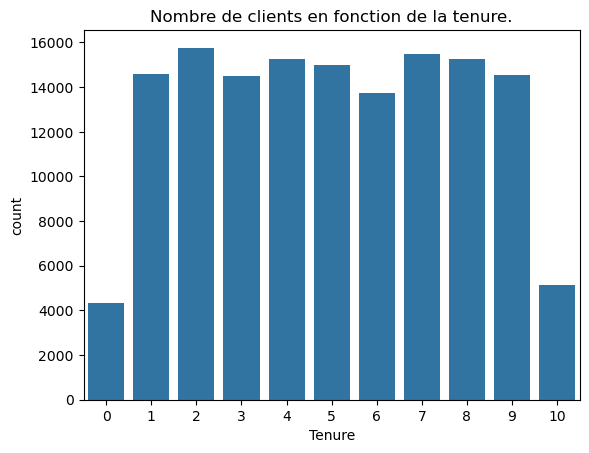

In [15]:
sns.countplot(data=train_set, x="Tenure")
plt.title("Nombre de clients en fonction de la tenure.")
plt.show()

On voit que dans la premiére année de cette banque (Tenure = 10), il y avait une quantité de client qui étais assez petites. Ensuite durant la deuxiéme (Tenure = 9), il y avait une grosse augmentation de la fréquentation de la banque et ensuite la fréquentation est relativement constante entre la deuxiéme année et la dixiéme année (Tenure = 1). Et ensuite durant l'année en cours il y a une diminution du nombre de client. Cela veut dire soit que la banque est moins attractive ou c'est tous simplement due au fait que l'année est en cours.

#II.1.5.b) Analyse de la tenure par rapport à la target

In [16]:
pd.crosstab(train_set["Tenure"], train_set["Exited"])

Exited,0,1
Tenure,,
0,3234,1112
1,11281,3322
2,12692,3074
3,11171,3313
4,11787,3470
5,11685,3299
6,11010,2706
7,12560,2914
8,12221,3051


Il y a toujours plus de clients qui n'ont pas résilié que ceux qui ont résilié. On voit qu'il y a entre les tenures 1 et 2 une diminution des clients qui ont résilié et une augmentation pour les clients qui n'ont pas résilié. Entre une tenure de 2 et 3, on observe une augmentation des clients qui ont résilié et une diminution pour les clients qui n'ont pas résilié. Entre une tenure de 7 et 9, on a une augmentation des clients qui ont résilié et une diminution des clients qui n'ont pas résilié. Il y a donc une influence de la tenure sur la target.

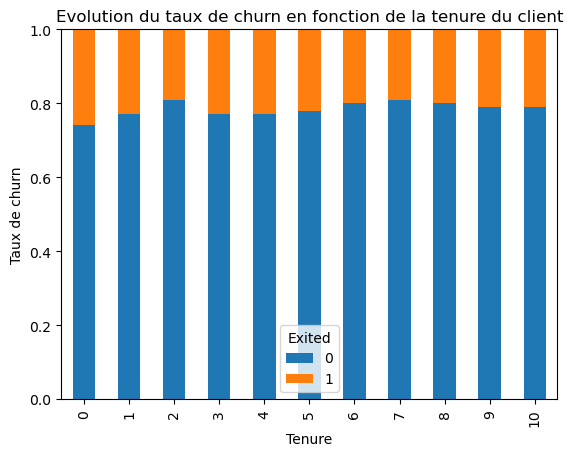

In [17]:
pd.crosstab(train_set["Tenure"], train_set["Exited"], normalize="index").round(2).plot(kind="bar", stacked=True)
plt.title("Evolution du taux de churn en fonction de la tenure du client")
plt.ylabel("Taux de churn")
plt.ylim(0, 1)
plt.show()

On voit que le taux de churn reste constant en fonction de la tenure et par conséquent il n'y a pas d'influence visible de la tenure sur la target. On va quand même faire un test d'hypothése.

In [18]:
print("H0: Il n'y a pas de relation entre la tenure et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["Tenure"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre la tenure et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, On peut dire avec un risque de se tromper de 2% qu'il y a bien une relation entre la Tenure et la target.

#II.1.6) Balance

#II.1.6.a) Analyse univarié

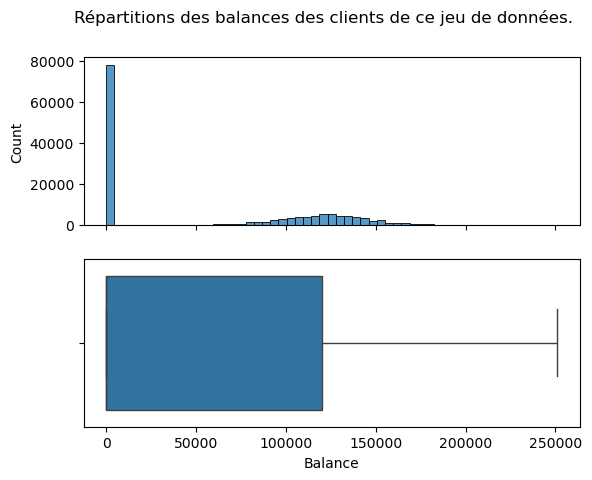

count    143579.000000
mean      55533.640642
std       62822.616346
min           0.000000
25%           0.000000
50%           0.000000
75%      119948.090000
max      250898.090000
Name: Balance, dtype: float64

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données.")
sns.histplot(data=train_set, x="Balance", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", ax=ax[1])
plt.show()
train_set["Balance"].describe()

On voit que la plupart des clients ont une balance égale à 0. On voit qu'il y a une loi normale séparer des balances égales à 0. Pas d'outliers sur la boxplot. La moyenne de la balance des clients de cette banque pour les trois pays du jeu de données est d'environ 55728.70 euros.

#II.1.6.b) Analyse de la balance par rapport à la target

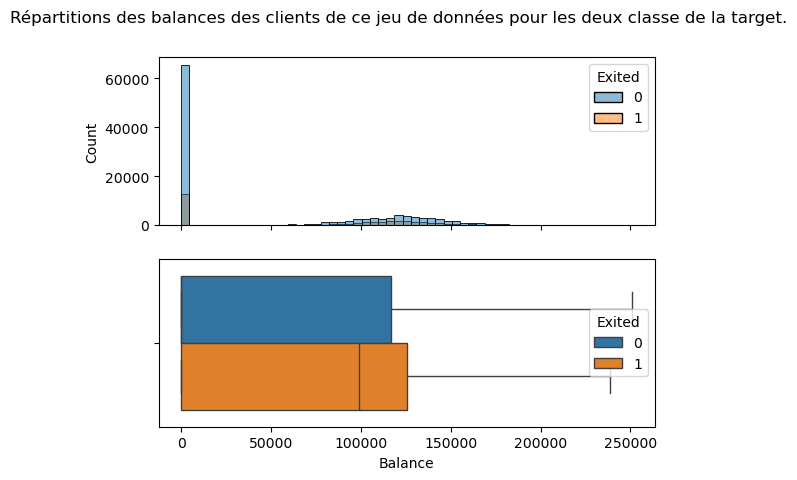

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,51274.230558,62196.885812,0.0,0.0,0.00,116811.12,250898.09
1,30450.0,71358.363247,62606.860862,0.0,0.0,98959.19,125521.18,238387.56


In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances des clients de ce jeu de données pour les deux classe de la target.")
sns.histplot(data=train_set, x="Balance", hue = "Exited", ax=ax[0])
sns.boxplot(data=train_set, x="Balance", hue = "Exited", ax=ax[1])
plt.show()
train_set.groupby("Exited")["Balance"].describe()

On voit qu'il n'y a pas de séparation des deux histogrammes mais qu'il y a des différences entre les deux moyennes. On voit que la différence entre nombre de client qui ont une balance égale à 0 et une balance différente de 0 est beaucoup plus grands pour le cas des clients qui n'ont pas résilié ce qui explique pourquoi en moyenne les clients qui n'ont pas résilié ont une moyenne de balance moins élevé que ceux qui ont résilié. Comme cette variable ne suit pas une loi normale, on ne peut pas faire un test de student, on le fera sur les balances différents de 0. Regardons maintenant la loi normale de plus prés.

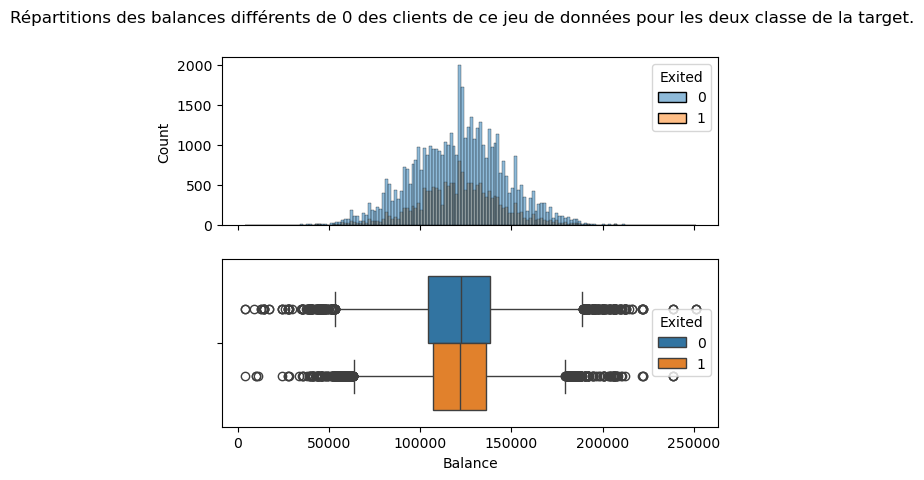

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,47803.0,121343.899521,25541.298733,3768.69,104154.250,122359.50,138023.520,250898.09
1,17858.0,121674.440635,23686.386782,3768.69,106920.255,121874.89,135927.445,238387.56


In [21]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des balances différents de 0 des clients de ce jeu de données pour les deux classe de la target.")
sns.histplot(data=train_set.query("`Balance` != 0"), x="Balance", hue = "Exited", ax=ax[0])
sns.boxplot(data=train_set.query("`Balance` != 0"), x="Balance", hue = "Exited", ax=ax[1])
plt.show()
train_set.query("`Balance` != 0").groupby("Exited")["Balance"].describe()

On voit cette fois-ci des outliers à droite et à gauche des deux boxplot. La boxplot des clients qui ont résilié est moins étendues que pour les clients qui n'ont pas résilié. Les deux moyennes sont similaire mais les écart-type sont différents. On va donc faire un test de student. La balance d'un client ne dépends pas des autres et il y a plus de 30 points par classes et les écart-type sont assez proche pour utiliser le test de student.

In [22]:
print("H0: Les clients qui n'ont pas résilié ont en moyenne la même balance différents de 0 que les clients qui n'ont pas résilié.")

alpha = 0.02

p_value = ttest_ind(train_set.query("`Balance` != 0 and `Exited` == 0")["Balance"], train_set.query("`Balance` != 0 and `Exited` == 1")["Balance"]).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les clients qui n'ont pas résilié ont en moyenne la même balance différents de 0 que les clients qui n'ont pas résilié.
Nous n'avons pas assez d'évidence pour rejeter H0.


Comme on n'a pas rejeter H0, on peut dire que les deux moyennes pour des balances différents de 0 ne sont pas significativement différentes. On en conclut que l'effet de la balance sur la target sera seulement au différences de nombres de clients entre les balance différent de 0 et égale à 0 pour les deux classes.

#II.1.7) NumOfProducts

#II.1.7.a) Analyse univarié

In [23]:
train_set["NumOfProducts"].value_counts()

NumOfProducts
2    73301
1    67364
3     2510
4      404
Name: count, dtype: int64

On voit que la plupart des clients ont 1 ou 2 produits et qu'il y a vraiment peu de cients qui ont 3 et 4 produit.

#II.1.7.b) Analyse du nombre de produit par rapport à la target

In [24]:
pd.crosstab(train_set["NumOfProducts"], train_set["Exited"])

Exited,0,1
NumOfProducts,,
1,43905,23459
2,68879,4422
3,292,2218
4,53,351


On voit qu'il y a plus de clients qui ont résilié que de client qui 'ont pas résilié parmis les clients qui ont 3 et 4 produits. On voit que parmis les clients qui ont résilié, il y a plus de clients qui ont 1 seul produit que 2 et c'est le contraire pour les clients qui n'ont pas résilié. Il y a donc une influence notable du nombre de produit par rapport à la target. On va faire un test.

In [25]:
print("H0: Il n'y a pas de relation entre le nombre de produit et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["NumOfProducts"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le nombre de produit et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de se trompé de 2% qu'il y a bien une relation entre le nombre de produit et la target.

#II.1.8) HasCrCard

#II.1.8.a) Analyse univarié

In [26]:
train_set["HasCrCard"].value_counts()

HasCrCard
1.0    108274
0.0     35305
Name: count, dtype: int64

On voit que la majorité des clients ont une carte de crédit.

#II.1.8.b) Analyse de HasCrCard par rapport à la target

In [27]:
pd.crosstab(train_set["HasCrCard"], train_set["Exited"])

Exited,0,1
HasCrCard,,
0.0,27246,8059
1.0,85883,22391


In [28]:
pd.crosstab(train_set["HasCrCard"], train_set["Exited"], normalize='index')

Exited,0,1
HasCrCard,,
0.0,0.771732,0.228268
1.0,0.793201,0.206799


On voit que dans les deux classes, il y a plus de clients qui posséde une carte de crédit mais on voit que le taux de churn est plus grand chez les clients qui n'ont pas de carte de crédit et c'est l'inverse pour ceux qui ont une carte de crédit. On va faire un test.

In [29]:
print("H0: Il n'y a pas de relation entre HasCrCard et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["HasCrCard"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre HasCrCard et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de ce trompé de 2% qu'il y a bien une relation entre HasCrCard et la target.

#II.1.9) IsActiveMember

#II.1.9.a) Analyse univarié

In [30]:
train_set["IsActiveMember"].value_counts()

IsActiveMember
0.0    72249
1.0    71330
Name: count, dtype: int64

On voit qu'il y a pratiquement autant de clients actifs que non actif. On peut donc tester cette hypothése.

In [31]:
print("H0: Il y a 50% de clients inactif.")

alpha = 0.02

p_value = binomtest(k=train_set["IsActiveMember"].value_counts()[1], n=len(train_set), p = 0.50).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il y a 50% de clients inactif.
Nous avons assez d'évidence pour rejeter H0


Comme on n'a réussi de rejeter H0, on peut donc dire avec un risque de 2% de se trompé qu'il y a autant de client actif que inactif dans cette banque.

#II.1.9.b) Analyse du status d'activité par rapport à la target 

In [32]:
pd.crosstab(train_set["IsActiveMember"], train_set["Exited"])

Exited,0,1
IsActiveMember,,
0.0,50742,21507
1.0,62387,8943


Parmis les clients qui ont résilié, il y a plus de clients inactif que de client actif et c'est l'inverse pour les clients qui n'ont pas résilié.  On va faire un test.

In [33]:
print("H0: Il n'y a pas de relation entre le status d'activité et la target.")

alpha = 0.02

p_value = chi2_contingency(pd.crosstab(train_set["IsActiveMember"], train_set["Exited"])).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Il n'y a pas de relation entre le status d'activité et la target.
Nous avons assez d'évidence pour rejeter H0


Comme on a rejeter H0, on peut dire avec un risque de se trompéde 2% qu'il y a bien une corrélation entre les status d'activité et la target.

#II.1.10) Salaire

#II.1.10.a) Analyse univarié

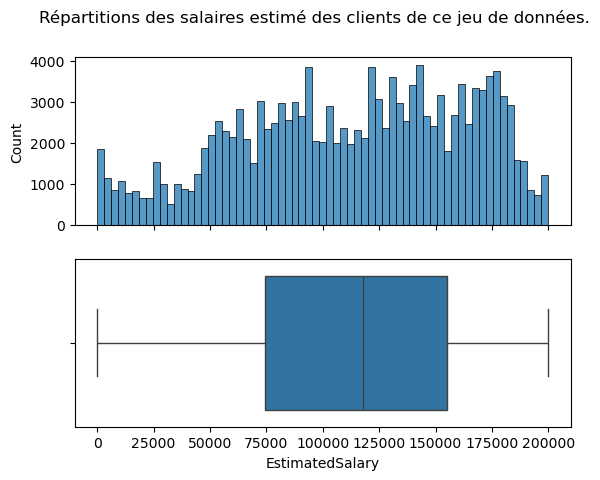

count    143579.000000
mean     112530.072465
std       50301.718378
min          11.580000
25%       74580.800000
50%      117931.100000
75%      155149.685000
max      199992.480000
Name: EstimatedSalary, dtype: float64

In [34]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartitions des salaires estimé des clients de ce jeu de données.")
sns.histplot(data=train_set, x="EstimatedSalary", ax=ax[0])
sns.boxplot(data=train_set, x="EstimatedSalary", ax=ax[1])
plt.show()
train_set["EstimatedSalary"].describe()

On voit que la moyenne des salaires estimé des clients de cette banque est de 112423 euros. Cette variable ne suit pas une loi normale. On observe aussi que le salaire minimum est de 11.58 qui correspond au smic horaire Français (environ égale à 1709 euros). Il faut savoir que les salaires estimé sont généralement des salaires mensuel et à temps plein. On voit que la plupart des salaires sont entre 40000 euros et 180000 euros ce qui est aussi bizarre pour des salaires mensuel. Il y a donc plusieurs types de salaires mais on voit qu'il y a vraiment beaucoup de salaire par type de salaire et par conséquent je pense que les estimations prend en compte la situation de la personne, c'est-à-dire qu'il y a peut-être une corrélation sur le type de salaire car les salaires payer à l'heure sont généralement pas les meilleurs.

#II.1.10.b) Analyse du salaire par rapport à la target

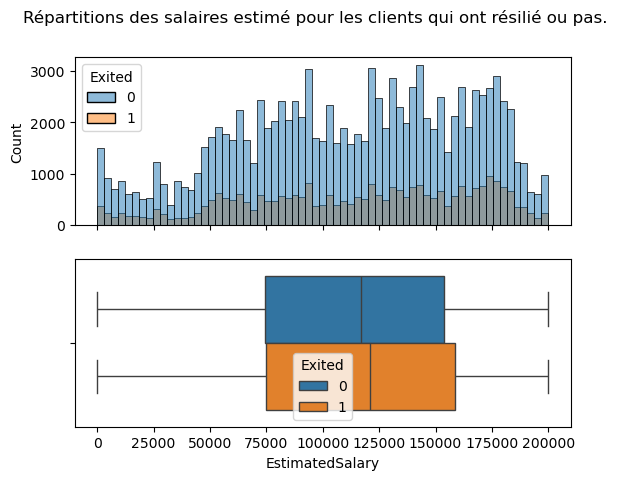

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,112024.082699,50228.170190,11.58,74287.53,116971.05,153727.32,199992.48
1,30450.0,114409.944918,50530.496339,11.58,74898.80,120893.77,158830.36,199992.48


In [35]:
fig, ax = plt.subplots(2, 1, sharex="col")
plt.suptitle("Répartitions des salaires estimé pour les clients qui ont résilié ou pas.")
sns.histplot(data=train_set, x="EstimatedSalary", hue = "Exited", ax=ax[0])
sns.boxplot(data=train_set, x="EstimatedSalary", hue = "Exited", ax=ax[1])
plt.show()
train_set.groupby("Exited")["EstimatedSalary"].describe()

On remarque qu'il n'y a pas du tous de séparation des histogrammes et que les boxplot sont presque les mêmes pour les deux types de salaire. On observe aussi que la moyenne de salaires des clients qui ont résilié est supérieur à celle des clients qui n'ont pas résilié. On voit que les clients qui résilié ont en moyenne un salaire plus élevé que les clients qui ne résilie pas. Comme le salaire estimé ne suit pas une loi normale, on ne peut pas faire de test de student. Aussi, comme les deux moyennes sont trés similaires, on peut émettre l'hypothése que cette variable décrit mal la target avec cette forme.

Voici les observations:

-Toutes les variables ont une influence statistiquement significatif sur la target

-Les clients qui ont résilié sont en moyennes moins fiable que les clients qui n'ont pas résilié.

-Il y a plus de clients qui vivent en France pour les deux classes de la target. 

-Il y a parmis les clients qui ont résilié plus de clients qui vive en Allemagne qu'en Espagne et c'est l'inverse pour les clients qui n'ont pas résilié.

-Il y a plus de femme que d'hommes parmis les clients qui résilie et c'est l'inverse pour ceux qui ne résilie pas.

-Les clients qui ont résilié sont en moyennes plus vieux que les clients qui n'ont pas résilié.

-Il y a entre les tenures 1 et 2 une diminution des clients qui ont résilié et une augmentation pour les clients qui n'ont pas résilié. 

-Entre une tenure de 2 et 3, on observe une augmentation des clients qui ont résilié et une diminution pour les clients qui n'ont pas résilié. 

-Entre une tenure de 7 et 9, on a une augmentation des clients qui ont résilié et une diminution des clients qui n'ont pas résilié.

-La plupart des clients de ce jeu ont une balance égale à 0 et la différence de client entre les balances différents de 0 et égale à 0 est plus petit pour le cas dess clients qui ont résilié que pour les clients qui n'ont pas résilié.

-Il y a plus de clients qui ont résilié que de client qui n'ont pas résilié parmis les clients qui ont 3 et 4 produits. 

-On voit que parmis les clients qui ont résilié, il y a plus de clients qui ont 1 seul produit que 2 et c'est le contraire pour les clients qui n'ont pas résilié.

-Le taux de churn est plus grand chez les clients qui n'ont pas de carte de crédit et c'est l'inverse pour ceux qui ont une carte de crédit.

-Il y a plus de clients inactif que de client actif et c'est l'inverse pour les clients qui n'ont pas résilié.


#II.2) Analyse des variables entre-eux

Dans cette section on va regarder toutes les surfaces scatter et regarder par rapport à la target pourvoir si il y a des surfaces séparables.

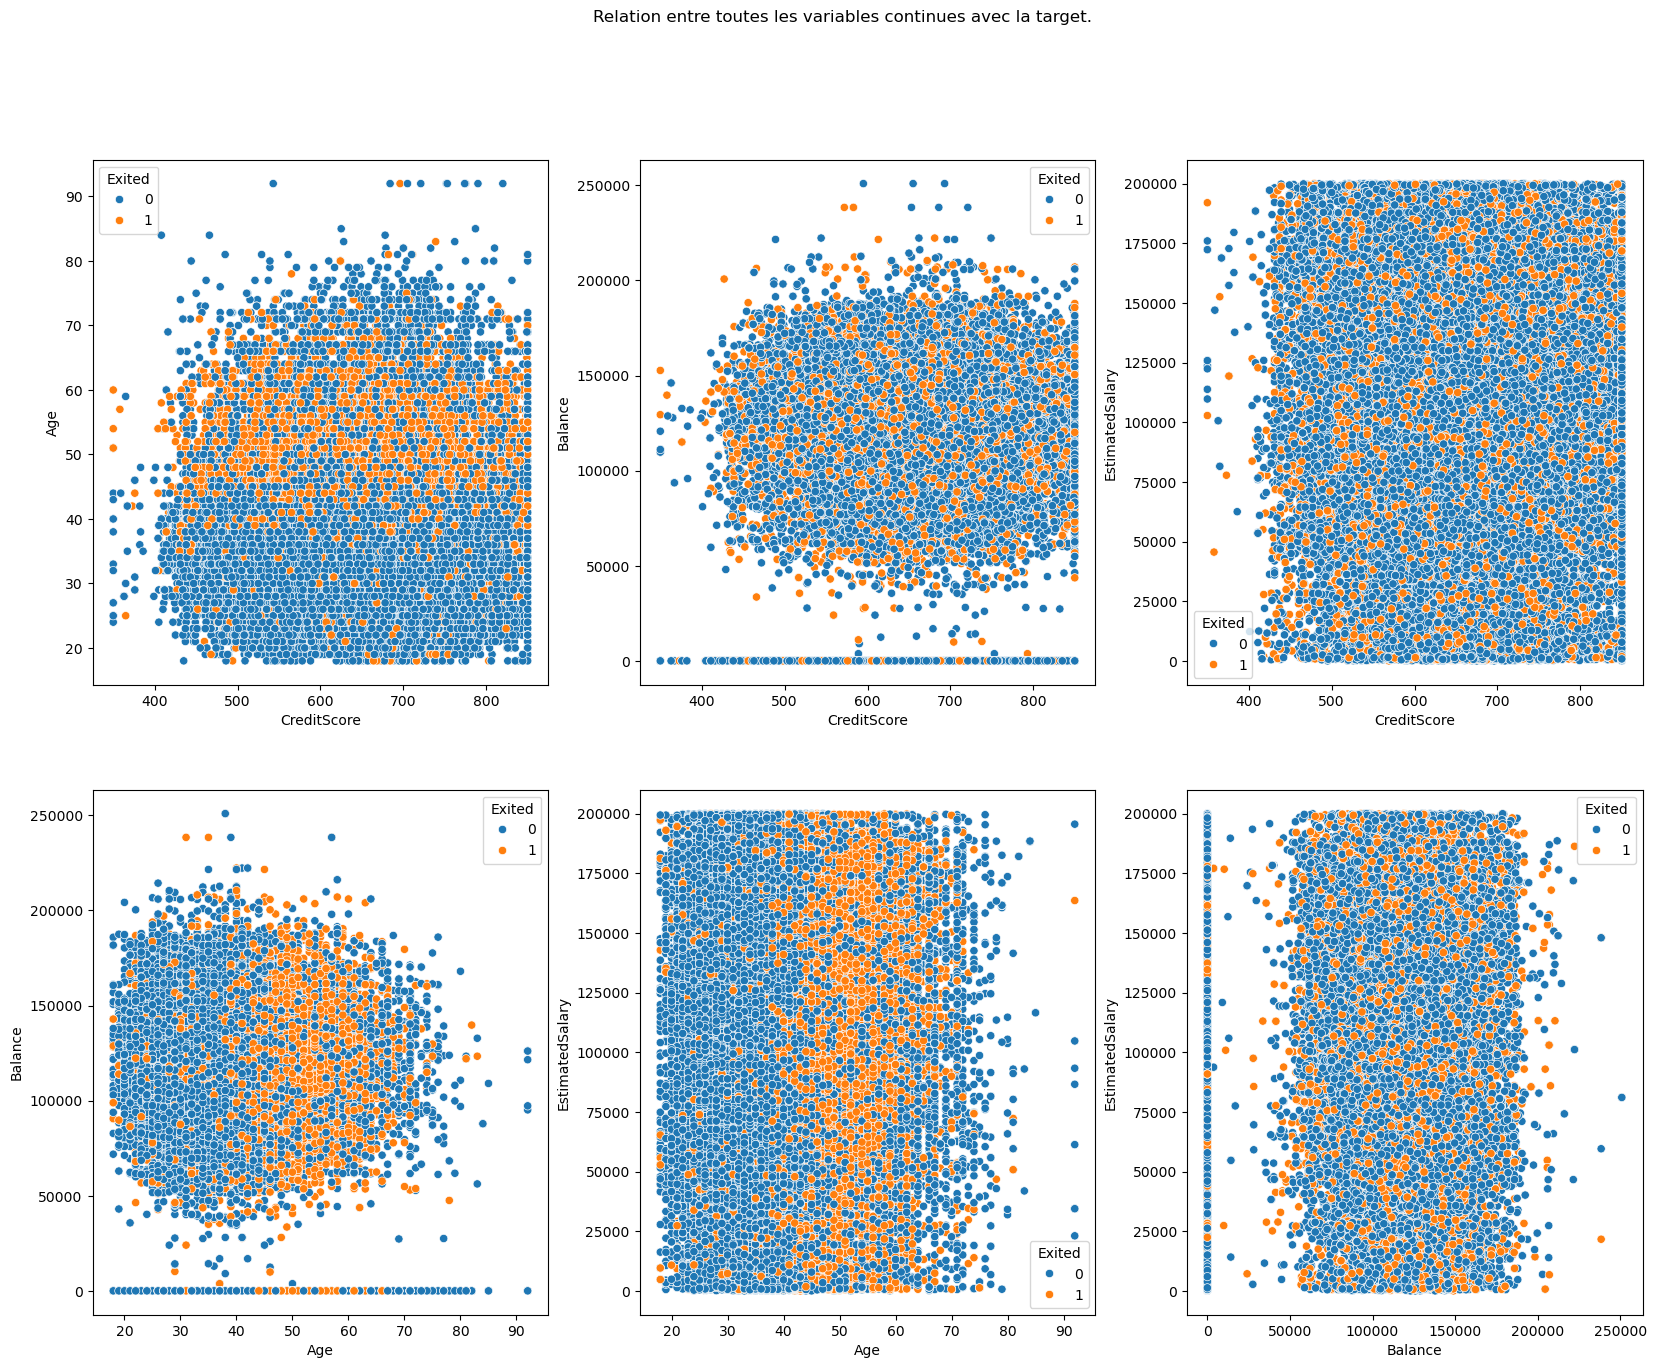

In [36]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 15)
plt.suptitle("Relation entre toutes les variables continues avec la target.")
sns.scatterplot(data = train_set, x="CreditScore", y="Age", hue="Exited", ax=ax[0, 0])
sns.scatterplot(data = train_set, x="CreditScore", y="Balance", hue="Exited", ax=ax[0, 1])
sns.scatterplot(data = train_set, x="CreditScore", y="EstimatedSalary", hue="Exited", ax=ax[0, 2])
sns.scatterplot(data = train_set, x="Age", y="Balance", hue="Exited", ax=ax[1, 0])
sns.scatterplot(data = train_set, x="Age", y="EstimatedSalary", hue="Exited", ax=ax[1, 1])
sns.scatterplot(data = train_set, x="Balance", y="EstimatedSalary", hue="Exited", ax=ax[1, 2])
plt.show()

On ne voit aucune surface dans lequel on peut séparer totalement les deux classes de la target. On voit que beaucoup de clients qui ont résilié ont comme âge entre 40 et 70 ans. On doit donc visualiser les variables entre-eux.

#III) Préprocéssing

#III.1) Nettoyage des données

Commençons par le nettoyage des données.

In [37]:
train_set.isna().value_counts()

ID     CustomerId  Surname  CreditScore  Geography  Gender  Age    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited
False  False       False    False        False      False   False  False   False    False          False      False           False            False     143579
Name: count, dtype: int64

On voit qu'il n'y a pas de valeur vide dans le jeu de train. Durant l'analyse précédente on n'a pas vue d'outliers vraiment significatifs. On va aussi nettoyer les variables inutiles.

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

X_train_set = train_set.drop("Exited", axis=1)
y_train_set = train_set["Exited"]

set_config(transform_output='pandas')

#III.2) Encoding

On voit qu'il y a trois variables à encoder qui sont le nom, le pays de résidence et le genre mais on va seulement encoder le pays de résidence et le genre car on supprimera le nom. La variable du genre est une variable binaire et le pays est une variable non ordinal et par conséquent on utilisera seulement un onehot encoder pour les deux variables. 

In [39]:
categorical_column = ["Geography", "Gender"]
encoder = ColumnTransformer(
    [
        ("Encoding_onehot", OneHotEncoder(sparse_output=False, drop='first', handle_unknown="ignore"), categorical_column)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)
encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('Encoding_onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Geography', 'Gender'])],
                  verbose_feature_names_out=False)

In [40]:
X_train_set_copy = X_train_set.copy()
column_encoders = encoder.fit_transform(X_train_set_copy)
column_encoders

,Geography_Germany,Geography_Spain,Gender_Male,ID,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.0,0.0,1.0,37765,15794860,Ch'eng,627,28.0,7,131694.04,1,1.0,1.0,161205.61
1,0.0,0.0,1.0,130453,15728005,Hargreaves,597,34.0,2,0.00,2,0.0,1.0,181419.29
2,0.0,0.0,1.0,77297,15686810,Ts'ui,724,39.0,7,0.00,2,1.0,1.0,100862.54
3,1.0,0.0,0.0,40858,15760244,Trevisano,663,56.0,5,118577.24,3,1.0,0.0,61164.45
4,0.0,0.0,0.0,19804,15810563,French,627,33.0,5,0.00,2,1.0,1.0,103737.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,1.0,0.0,1.0,97639,15759915,Onwumelu,559,45.0,3,111634.29,1,1.0,1.0,103349.74
143575,1.0,0.0,1.0,95939,15769974,Shih,597,41.0,10,119182.73,1,0.0,0.0,121299.14
143576,0.0,1.0,1.0,152315,15592028,Hsiao,576,31.0,6,127299.56,1,1.0,1.0,57569.89
143577,0.0,0.0,0.0,117952,15804009,Ch'ang,751,27.0,4,90721.11,1,0.0,0.0,84496.78


3. Feature engineerings

In [41]:
column_encoders["Log(Balance)"] = np.log(column_encoders["Balance"] + 1)
column_encoders

,Geography_Germany,Geography_Spain,Gender_Male,ID,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Log(Balance)
0,0.0,0.0,1.0,37765,15794860,Ch'eng,627,28.0,7,131694.04,1,1.0,1.0,161205.61,11.788244
1,0.0,0.0,1.0,130453,15728005,Hargreaves,597,34.0,2,0.00,2,0.0,1.0,181419.29,0.000000
2,0.0,0.0,1.0,77297,15686810,Ts'ui,724,39.0,7,0.00,2,1.0,1.0,100862.54,0.000000
3,1.0,0.0,0.0,40858,15760244,Trevisano,663,56.0,5,118577.24,3,1.0,0.0,61164.45,11.683328
4,0.0,0.0,0.0,19804,15810563,French,627,33.0,5,0.00,2,1.0,1.0,103737.82,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,1.0,0.0,1.0,97639,15759915,Onwumelu,559,45.0,3,111634.29,1,1.0,1.0,103349.74,11.622992
143575,1.0,0.0,1.0,95939,15769974,Shih,597,41.0,10,119182.73,1,0.0,0.0,121299.14,11.688422
143576,0.0,1.0,1.0,152315,15592028,Hsiao,576,31.0,6,127299.56,1,1.0,1.0,57569.89,11.754306
143577,0.0,0.0,0.0,117952,15804009,Ch'ang,751,27.0,4,90721.11,1,0.0,0.0,84496.78,11.415556


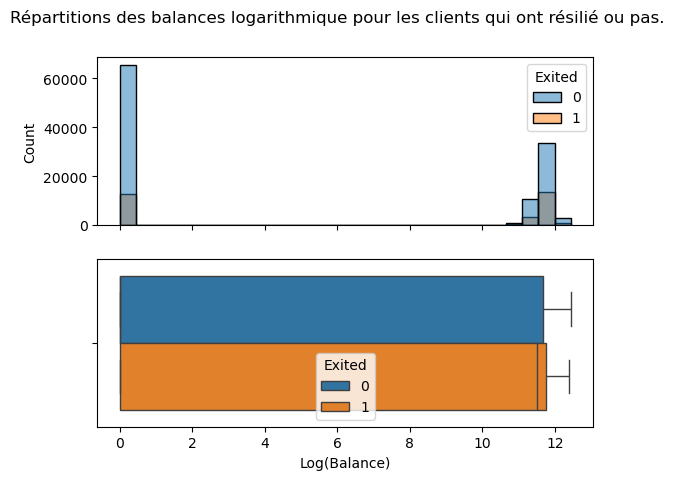

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,4.936303,5.772486,0.0,0.0,0.000000,11.668322,12.432806
1,30450.0,6.854789,5.758457,0.0,0.0,11.502473,11.740238,12.381657


In [42]:
fig, ax = plt.subplots(2, 1, sharex="col")
plt.suptitle("Répartitions des balances logarithmique pour les clients qui ont résilié ou pas.")
sns.histplot(data=column_encoders, x="Log(Balance)", hue = y_train_set, ax=ax[0])
sns.boxplot(data=column_encoders, x="Log(Balance)", hue = y_train_set, ax=ax[1])
plt.show()
column_encoders.groupby(y_train_set)["Log(Balance)"].describe()

In [61]:
column_encoders["Balance-to-Products Ratio"] = column_encoders["Balance"] / column_encoders["NumOfProducts"]
column_encoders

,Geography_Germany,Geography_Spain,Gender_Male,ID,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Log(Balance),Balance-to-Salary Ratio,Balance-to-Products Ratio
0,0.0,0.0,1.0,37765,15794860,Ch'eng,627,28.0,7,131694.04,1,1.0,1.0,161205.61,11.788244,0.816932,131694.040000
1,0.0,0.0,1.0,130453,15728005,Hargreaves,597,34.0,2,0.00,2,0.0,1.0,181419.29,0.000000,0.000000,0.000000
2,0.0,0.0,1.0,77297,15686810,Ts'ui,724,39.0,7,0.00,2,1.0,1.0,100862.54,0.000000,0.000000,0.000000
3,1.0,0.0,0.0,40858,15760244,Trevisano,663,56.0,5,118577.24,3,1.0,0.0,61164.45,11.683328,1.938663,39525.746667
4,0.0,0.0,0.0,19804,15810563,French,627,33.0,5,0.00,2,1.0,1.0,103737.82,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143574,1.0,0.0,1.0,97639,15759915,Onwumelu,559,45.0,3,111634.29,1,1.0,1.0,103349.74,11.622992,1.080160,111634.290000
143575,1.0,0.0,1.0,95939,15769974,Shih,597,41.0,10,119182.73,1,0.0,0.0,121299.14,11.688422,0.982552,119182.730000
143576,0.0,1.0,1.0,152315,15592028,Hsiao,576,31.0,6,127299.56,1,1.0,1.0,57569.89,11.754306,2.211218,127299.560000
143577,0.0,0.0,0.0,117952,15804009,Ch'ang,751,27.0,4,90721.11,1,0.0,0.0,84496.78,11.415556,1.073664,90721.110000


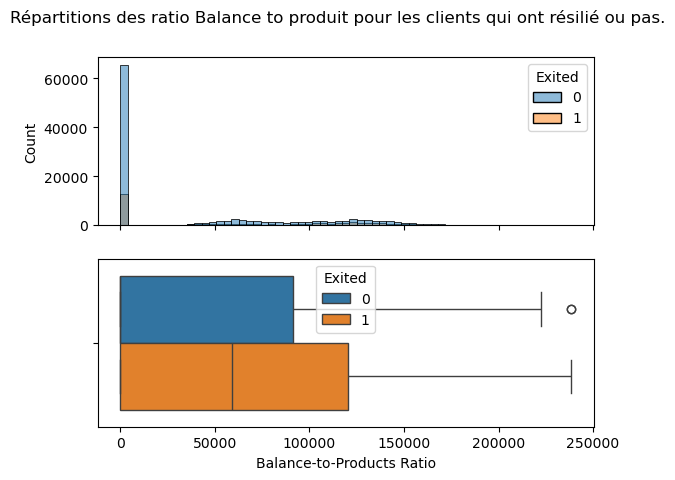

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,113129.0,42693.716100,55214.747207,0.0,0.0,0.000,91215.9000,238387.56
1,30450.0,62580.428088,59423.586086,0.0,0.0,58932.425,120297.7175,238387.56


In [62]:
fig, ax = plt.subplots(2, 1, sharex="col")
plt.suptitle("Répartitions des ratio Balance to produit pour les clients qui ont résilié ou pas.")
sns.histplot(data=column_encoders, x="Balance-to-Products Ratio", hue = y_train_set, ax=ax[0])
sns.boxplot(data=column_encoders, x="Balance-to-Products Ratio", hue = y_train_set, ax=ax[1])
plt.show()
column_encoders.groupby(y_train_set)["Balance-to-Products Ratio"].describe()

3. Normalisation

In [69]:
normalizer = ColumnTransformer(
    [
        ("Standard", StandardScaler(), ["Age", "IsActiveMember", "Geography_Germany", "Balance-to-Products Ratio"])
    ],
    remainder="drop",
    verbose_feature_names_out=False
)
normalizer

ColumnTransformer(transformers=[('Standard', StandardScaler(),
                                 ['Age', 'IsActiveMember', 'Geography_Germany',
                                  'Balance-to-Products Ratio'])],
                  verbose_feature_names_out=False)

In [70]:
final_column = normalizer.fit_transform(column_encoders)
final_column

,Age,IsActiveMember,Geography_Germany,Balance-to-Products Ratio
0,-1.143467,1.006421,-0.515076,1.494789
1,-0.467158,1.006421,-0.515076,-0.827083
2,0.096433,1.006421,-0.515076,-0.827083
3,2.012643,-0.993620,1.941462,-0.130213
4,-0.579876,1.006421,-0.515076,-0.827083
...,...,...,...,...
143574,0.772742,1.006421,1.941462,1.141119
143575,0.321870,-0.993620,1.941462,1.274204
143576,-0.805313,1.006421,-0.515076,1.417310
143577,-1.256186,-0.993620,-0.515076,0.772403


In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        # Apprendre les paramètres à partir de X si nécessaire
        return self

    def transform(self, X, y=None):
        X["Log(Balance)"] = np.log(X["Balance"] + 1)
        X["Balance-to-Products Ratio"] = X["Balance"] / X["NumOfProducts"]
        return X

pipeline = make_pipeline(encoder, CustomTransformer(), normalizer)
pipeline

/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encoding_onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography', 'Gender'])],
                                   verbose_feature_names_out=False)),
                ('customtransformer', CustomTransformer()),
                ('columntransformer-2',
                 ColumnTransformer(transformers=[('Standard', StandardScaler(),
                                                  ['Age', 'IsActiveMember',
                                                   'Geography_Germany',
                                                   'Balance-to-Products '
                                                   'Ratio'])],
                                   verbose_feature_names_out=False))])

In [72]:
train_set_finale = pipeline.fit_transform(X_train_set)
train_set_finale

,Age,IsActiveMember,Geography_Germany,Balance-to-Products Ratio
0,-1.143467,1.006421,-0.515076,1.494789
1,-0.467158,1.006421,-0.515076,-0.827083
2,0.096433,1.006421,-0.515076,-0.827083
3,2.012643,-0.993620,1.941462,-0.130213
4,-0.579876,1.006421,-0.515076,-0.827083
...,...,...,...,...
143574,0.772742,1.006421,1.941462,1.141119
143575,0.321870,-0.993620,1.941462,1.274204
143576,-0.805313,1.006421,-0.515076,1.417310
143577,-1.256186,-0.993620,-0.515076,0.772403


#III) Modélisation

On va tester les 3 modéles du cours et prendre le meilleur.
On va commencer par régréssion logistique.

In [74]:
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2', 'auto'],
    'splitter': ['best', 'random']
}

grisearch = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="f1")
grisearch.fit(train_set_finale, y_train_set)

/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3360 fits failed out of a total of 13440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3360 fits failed with the following error:
Traceback (most recent call last):
  File "/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/florian/anaconda3/envs/bank_churn_project_env/lib/python3.11/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/florian/anaconda3/envs/bank_churn_project_env/lib/p

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10, 20, 30, 40, 50],
                         'max_features': [None, 'sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [75]:
print(grisearch.best_params_)
print(grisearch.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
0.5336424997362302


In [ ]:
test_set = pd.read_csv("test_data.csv")
test_set.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,67897,15585246,Bancks,585,France,Female,53.0,2,0.00,2,1.0,1.0,91830.75
1,163075,15604551,Robb,606,France,Male,24.0,2,0.00,1,0.0,1.0,90876.95
2,134760,15729040,Ugochukwu,633,Germany,Male,44.0,1,118907.60,1,1.0,0.0,47777.15
3,68707,15792329,Hs?,602,Germany,Male,40.0,2,149961.99,2,1.0,1.0,82696.84
4,3428,15617166,Genovesi,645,France,Male,31.0,4,132351.29,1,1.0,0.0,151887.16


In [ ]:
test_set["Correct_salary"] = test_set["EstimatedSalary"] * correction_salary(test_set, 1709, 1166, 2200)
test_set

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Correct_salary
0,67897,15585246,Bancks,585,France,Female,53.0,2,0.00,2,1.0,1.0,91830.75,7652.562500
1,163075,15604551,Robb,606,France,Male,24.0,2,0.00,1,0.0,1.0,90876.95,7573.079167
2,134760,15729040,Ugochukwu,633,Germany,Male,44.0,1,118907.60,1,1.0,0.0,47777.15,3981.429167
3,68707,15792329,Hs?,602,Germany,Male,40.0,2,149961.99,2,1.0,1.0,82696.84,6891.403333
4,3428,15617166,Genovesi,645,France,Male,31.0,4,132351.29,1,1.0,0.0,151887.16,12657.263333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,24790,15697574,Lucchese,685,France,Male,35.0,4,0.00,2,1.0,1.0,175072.47,14589.372500
21451,152608,15682708,Tuan,648,Spain,Female,47.0,3,0.00,1,1.0,0.0,156680.71,13056.725833
21452,28134,15614215,Ebelegbulam,607,France,Female,32.0,3,0.00,2,1.0,1.0,173599.38,14466.615000
21453,123871,15587573,Manna,705,France,Female,56.0,0,0.00,1,1.0,0.0,161479.19,13456.599167


In [ ]:
test_set_finale = pipeline.transform(test_set)
test_set_finale

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Correct_salary
0,-0.515076,-0.531092,-1.137153,-0.890308,1.674488,-1.075308,-0.883978,0.815851,0.571026,1.006421,-0.558932
1,-0.515076,-0.531092,0.879389,-0.628496,-1.594340,-1.075308,-0.883978,-1.013133,-1.751233,1.006421,-0.579048
2,1.941462,-0.531092,0.879389,-0.291880,0.660024,-1.431558,1.008780,-1.013133,0.571026,-0.993620,-1.488050
3,1.941462,-0.531092,0.879389,-0.678365,0.209151,-1.075308,1.503100,0.815851,0.571026,1.006421,-0.751572
4,-0.515076,-0.531092,0.879389,-0.142273,-0.805313,-0.362808,1.222775,-1.013133,0.571026,-0.993620,0.707695
...,...,...,...,...,...,...,...,...,...,...,...
21450,-0.515076,-0.531092,0.879389,0.356418,-0.354440,-0.362808,-0.883978,0.815851,0.571026,1.006421,1.196688
21451,-0.515076,1.882914,-1.137153,-0.104871,0.998179,-0.719058,-0.883978,-1.013133,0.571026,-0.993620,0.808794
21452,-0.515076,-0.531092,-1.137153,-0.616029,-0.692594,-0.719058,-0.883978,0.815851,0.571026,1.006421,1.165620
21453,-0.515076,-0.531092,-1.137153,0.605763,2.012643,-1.787808,-0.883978,-1.013133,0.571026,-0.993620,0.909997


In [ ]:
best_model = grisearch.best_estimator_

ypred = best_model.predict(test_set_finale)
ypred

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
results = pd.DataFrame(
    {
        "ID": test_set["ID"],
        "Exited": ypred
    }
)
results.set_index("ID")

,Exited
ID,
67897,0
163075,0
134760,1
68707,0
3428,0
...,...
24790,0
152608,1
28134,0


In [ ]:
results.to_csv("submission.csv")